# Autoencoders

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [5]:

# Transformations of data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for CIFAR-10
])

# Load CIFAR-10 dataset and create dataloaders
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)



100%|██████████| 170498071/170498071 [00:25<00:00, 6819528.01it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [4]:
autoencoder = Autoencoder()

# Definir la función de pérdida y el optimizador
criterion = nn.BCELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Entrenamiento del autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.view(-1, 784)
        optimizer.zero_grad()
        outputs = autoencoder(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    average_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

# Obtener las representaciones codificadas de los datos de entrenamiento
encoded_imgs = []
with torch.no_grad():
    for images, _ in train_loader:
        images = images.view(-1, 784)
        encoded = autoencoder.encoder(images)
        encoded_imgs.append(encoded)
encoded_imgs = torch.cat(encoded_imgs, dim=0)

RuntimeError: all elements of target should be between 0 and 1

In [ ]:
print(encoded_imgs.shape)
print (encoded_imgs)

torch.Size([60000, 32])
tensor([[  6.5433,  -7.8309,  14.5471,  ...,  73.0008,  97.9721,  11.9257],
        [ 33.9607,   3.8001,  -8.9526,  ...,   0.2264,  49.4532,  62.8196],
        [ 53.2801, -17.2195,  20.3389,  ...,  67.6179, 116.5745,  -2.9910],
        ...,
        [ 38.3473,   4.7853, -32.7170,  ...,  24.7253,  72.2748,  57.5098],
        [-31.2450,   5.0998, -26.7780,  ...,  15.9423,  56.6592,   6.8362],
        [-15.4077,  10.3041, -12.5182,  ...,  61.3990,  48.8304,  15.7332]])


# Visualizando la reconstrucción

Epoch 1/50
235/235 [==============================] - 7s 21ms/step - loss: 0.2397 - val_loss: 0.1631
Epoch 2/50
235/235 [==============================] - 4s 16ms/step - loss: 0.1472 - val_loss: 0.1351
Epoch 3/50
235/235 [==============================] - 4s 16ms/step - loss: 0.1307 - val_loss: 0.1233
Epoch 4/50
235/235 [==============================] - 4s 17ms/step - loss: 0.1209 - val_loss: 0.1163
Epoch 5/50
235/235 [==============================] - 4s 19ms/step - loss: 0.1152 - val_loss: 0.1121
Epoch 6/50
235/235 [==============================] - 4s 18ms/step - loss: 0.1112 - val_loss: 0.1080
Epoch 7/50
235/235 [==============================] - 4s 18ms/step - loss: 0.1077 - val_loss: 0.1049
Epoch 8/50
235/235 [==============================] - 4s 18ms/step - loss: 0.1047 - val_loss: 0.1024
Epoch 9/50
235/235 [==============================] - 4s 17ms/step - loss: 0.1024 - val_loss: 0.1002
Epoch 10/50
235/235 [==============================] - 4s 17ms/step - loss: 0.1005 - val_lo

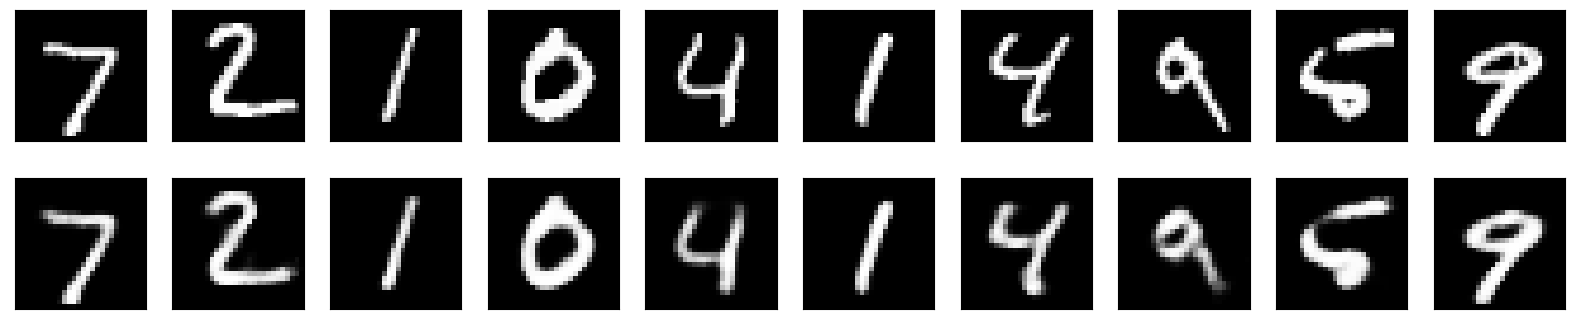

In [ ]:
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense

# Cargar los datos de MNIST y dividirlos en conjuntos de entrenamiento y prueba
(x_train, _), (x_test, _) = mnist.load_data()

# Preprocesar los datos: aplanar las imágenes y normalizar los valores de píxeles
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), -1))
x_test = x_test.reshape((len(x_test), -1))

# Definir la arquitectura del autoencoder
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

# Crear el modelo del autoencoder
autoencoder = Model(input_img, decoded)

# Compilar el modelo
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Entrenar el autoencoder
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

# Obtener las imágenes reconstruidas del conjunto de prueba
reconstructed_imgs = autoencoder.predict(x_test)

# Visualizar algunas imágenes originales y reconstruidas
import matplotlib.pyplot as plt

n = 10  # número de imágenes a mostrar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reconstruida
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Utilizando el vector Latente

In [ ]:
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense
from keras.utils import to_categorical

# Cargar los datos de MNIST y dividirlos en conjuntos de entrenamiento y prueba
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocesar los datos: aplanar las imágenes y normalizar los valores de píxeles
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), -1))
x_test = x_test.reshape((len(x_test), -1))

# Definir la arquitectura del autoencoder
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
latent = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(latent)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

# Crear el modelo del autoencoder
autoencoder = Model(input_img, decoded)

# Compilar el modelo
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Entrenar el autoencoder
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

# Obtener el vector latente (representación codificada)
encoder = Model(input_img, latent)
encoded_train = encoder.predict(x_train)
encoded_test = encoder.predict(x_test)

# Convertir las etiquetas a codificación one-hot
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Definir la arquitectura del clasificador utilizando el vector latente como entrada
input_latent = Input(shape=(32,))
output = Dense(10, activation='softmax')(input_latent)

# Crear el modelo del clasificador
classifier = Model(input_latent, output)

# Compilar el modelo del clasificador
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el clasificador utilizando el vector latente como características de entrada
classifier.fit(encoded_train, y_train,
               epochs=10,
               batch_size=256,
               validation_data=(encoded_test, y_test))

# Evaluar el rendimiento del clasificador en el conjunto de prueba
loss, accuracy = classifier.evaluate(encoded_test, y_test)
print("Pérdida de clasificación:", loss)
print("Exactitud de clasificación:", accuracy)

Epoch 1/50
235/235 [==============================] - 4s 14ms/step - loss: 0.2452 - val_loss: 0.1688
Epoch 2/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1511 - val_loss: 0.1374
Epoch 3/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1304 - val_loss: 0.1223
Epoch 4/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1195 - val_loss: 0.1143
Epoch 5/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1134 - val_loss: 0.1098
Epoch 6/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1091 - val_loss: 0.1057
Epoch 7/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1057 - val_loss: 0.1030
Epoch 8/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1033 - val_loss: 0.1011
Epoch 9/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1012 - val_loss: 0.0990
Epoch 10/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0994 - val_loss: 0.097